In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Making the dataset
We will use all of the datasets in the slides, implmenting the process that we described to calculate win/lose/draws ratios, form and home result.

In [2]:
#loading historical matches
league = pd.read_csv("england.csv")
league = league[league.Season >= 1990].reset_index(drop = True)
league = league[["Date", "Season", "home", "visitor", "hgoal", "vgoal"]]


facup = pd.read_csv("facup.csv")
facup = facup[facup.Season >= 1990].reset_index(drop = True)
facup = facup[["Date", "Season", "home", "visitor", "hgoal", "vgoal"]]


leaguecup = pd.read_csv("leaguecup.csv")
leaguecup = leaguecup[leaguecup.Season >= 1990].reset_index(drop = True)
leaguecup = leaguecup[["Date", "Season", "home", "visitor", "hgoal", "vgoal"]]


playoffs = pd.read_csv("englandplayoffs.csv")
playoffs = playoffs[playoffs.Season >= 1990].reset_index(drop = True)
playoffs = playoffs[["Date", "Season", "home", "visitor", "hgoal", "vgoal"]]


league18 = pd.read_csv("league 2018.csv")
only_date = lambda x: x[0:10]
league18["Date"] = league18.Date.apply(only_date)
league18["Date"] =pd.to_datetime(league18.Date, format='%d/%m/%Y')
home_score = lambda x: x[0]
visitor_score = lambda x: x[4]
league18["hgoal"] = league18.Result.apply(home_score)
league18["vgoal"] = league18.Result.apply(visitor_score)
league18.drop(columns=['Result'],inplace = True)


#putting all historical matches in one dataframe
match_records = pd.concat([league,facup,leaguecup,playoffs,league18]).reset_index(drop = True)
match_records["Date"] =pd.to_datetime(match_records.Date)
match_records = match_records.sort_values(by="Date").reset_index(drop = True)
match_records.dropna(how="all", inplace=True)
match_records['home_result'] = match_records.apply(lambda row: "win" if row['hgoal'] > row['vgoal'] else ("draw" if row['hgoal'] == row['vgoal'] else "loss"), axis = 1)
match_records = match_records[["Date", "Season", "home", "visitor", "home_result"]]



#calculating historic win/draw/lose percentages
def historic_percentages(row):
    number_of_matches = 10
    matches = match_records[(match_records.home == row.home) & (match_records.visitor == row.visitor) & (match_records.Season < row.Season)].tail(number_of_matches)
    number_of_matches = matches["home"].count()
    if number_of_matches == 0:
        return 1/3,1/3,1/3
    count_series = matches.home_result.value_counts()
    indices = count_series.index.tolist()
    counts = count_series.to_frame().transpose()
    if "win" in indices:
        win = int(counts["win"])/number_of_matches
    else:
        win = 0
    if "draw" in indices:
        draw = int(counts["draw"])/number_of_matches
    else:
        draw = 0
    if "loss" in indices:
        loss = int(counts["loss"])/number_of_matches
    else:
        loss = 0
    return win, draw, loss

fixtures = pd.read_csv("Fixtures_16_to_19.csv")
fixtures["win%"], fixtures["draw%"], fixtures["loss%"] =  zip(*fixtures.apply(historic_percentages, axis = 1))

#adding historical percentages to main data
df = pd.read_csv("Spi.csv")
df = pd.merge(df,fixtures, how="left")
df["Date"] =pd.to_datetime(df.Date)
match_records = match_records.drop_duplicates()
df = pd.merge(df,match_records, how="left")


#projecting the rest of 2019 league positions based on history only
def league_points_calculator(row):
    if row['home'] == i:
        return 3*row["prob1"] + 1*row["probtie"]
    else:
        return 3*row["prob2"] + 1*row["probtie"]

df_2019 = df[df.Season == 2019]
teams_2019 = df_2019.home.unique()

tables = []
for i in teams_2019:

    cursor = df[((df.Season == 2019) & (df.Round > 16)) & ((df.home == i)|(df.visitor == i))][["Date", "Season", "Round", "home", "visitor", "prob1", "prob2", "probtie"]]
    cursor['points'] = cursor.apply(league_points_calculator, axis = 1)
    tables.append((cursor[["Round","points"]].rename(columns={"points": i}).set_index('Round').T))

cursor = pd.concat(tables).reset_index()
z =pd.read_csv("2019_round16_points.csv").set_index('index').reset_index()
rest_of_2019 = pd.merge(z,cursor).rename(columns={"16": 16})

#making a per round league table (points) of the rest of 2019 based on history only
def points_adder(table):
    for i in range(17,39):
        table[i] = table[i] + table[i-1]
    return table

rest_of_2019 = points_adder(rest_of_2019)

#making a table of per round league table (positions) of the rest of 2019 based on history only
for i in range(16,39):
    rest_of_2019 = rest_of_2019.sort_values(by=[i],ascending=False)
    rest_of_2019[i] = list(range(1,21))


#adding home team legue position and visitor team league position to every match in the main dataframe
pos_2016 = pd.read_csv("2016_league_positions.csv")
pos_2017 = pd.read_csv("2017_league_positions.csv")
pos_2018 = pd.read_csv("2018_league_positions.csv")

pos_2019_until_16 = pd.read_csv("2019_league_positions_round 16.csv")
def positionator(row, season, df_, from_, to_, home):
    if home:
        x = row.home
    else:
        x = row.visitor
    if row.Season == season and row.Round in list(range(from_,to_)):
        if season == 2019 and from_>16:
            return float(df_[(row.Round)][df_["index"] == x])
        else:
            return float(df_[str(row.Round)][df_["index"] == x])
    else:
        if home:
            return float(row.home_pos)
        else:
            return float(row.visitor_pos)

iterator = [((2016, pos_2016, 1, 39, True), (2016, pos_2016, 1, 39, False)), ((2017, pos_2017, 1, 39, True), (2017, pos_2017, 1, 39, False)), ((2018, pos_2018, 1, 39, True), (2018, pos_2018, 1, 39, False)), ((2019, pos_2019_until_16, 1, 17, True), (2019, pos_2019_until_16, 1, 17, False)), ((2019, rest_of_2019, 17, 39, True), (2019, rest_of_2019, 17, 39, False))]

df['home_pos'] ,df['visitor_pos'] = 21, 21

for i in iterator:
    df['home_pos'] = df.apply(positionator, args=i[0], axis = 1)
    df['visitor_pos'] = df.apply(positionator, args=i[1], axis = 1)


#adding average 2019 xG and xGA to every team in the rest of 2019
df['xG1'] = df["xg1"] + df["nsxg1"]
df['xG2'] = df["xg2"] + df["nsxg2"]
average_2019_xg = pd.read_csv("Average_2019_xG.csv")
def home_xG(row):
    if row.Season == 2019 and row.Round > 16:
        return float(average_2019_xg["xG"][average_2019_xg["index"] == row.home])
    else:
        return float(row.xg1)


def visitor_xG(row):
    if row.Season == 2019 and row.Round > 16:
        return float(average_2019_xg["xG"][average_2019_xg["index"] == row.visitor])
    else:
        return float(row.xg2)


df['xG1'] = df.apply(home_xG, axis = 1)
df['xG2'] = df.apply(visitor_xG, axis = 1)

cursor = df.iloc[0:1320].copy()

def home_result_df(row):
    if row.score1 != np.nan:
        if row.score1 > row.score2:
            return "win"
        elif row.score1 == row.score2:
            return "draw"
        else:
            return "loss"
    else:
        return np.nan

cursor["home_result"] = cursor.apply(home_result_df, axis=1)
df.iloc[:1320,-5] = cursor["home_result"]

def results_corrector(row, team):
    team[0]
    if row.visitor == team:
        if row.home_result == "win":
            return "loss"
        elif row.home_result == "loss":
            return "win"
        else:
            return "draw"
    else:
        return row.home_result

def form_calculator(row, df, home):
    if home:
        x = row.home
    else:
        x = row.visitor
    number_of_matches = 5
    matches = df[((df.home == x) | (df.visitor == x)) & ((df.Season == row.Season) &(df.Round < row.Round))].tail(number_of_matches)[["home", "visitor", "home_result"]]
    number_of_matches = matches["home"].count()
    if number_of_matches == 0:
        return (7/5)
    matches["corrected_results"] = matches.apply(results_corrector, args=([x]), axis = 1)
    count_series = matches.corrected_results.value_counts()
    indices = count_series.index.tolist()
    counts = count_series.to_frame().transpose()
    counts_columns = counts.columns.tolist()
    if "win" in counts_columns:
        win_points = counts["win"]*3
    else:
        win_points = 0
    if "draw" in counts_columns:
        draw_points = counts["draw"]*1
    else:
        draw_points = 0
    return float(win_points + draw_points)/float(number_of_matches)
    
df["home_form"] = df.apply(form_calculator, args = (df, True), axis=1)
df["visitor_form"] = df.apply(form_calculator,args = (df, False),axis=1)

#arranging the main dataframe
df = df[['Date', 'Season', 'Round', 'home', 'visitor', 'home_pos', 'visitor_pos', 'spi1', 'spi2', 'win%', 'draw%', 'loss%', 'home_form', 'visitor_form', 'importance1', 'importance2', 'xG1', 'xG2', 'proj_score1', 'proj_score2', 'home_result', 'score1', 'score2']]

df_played_matches = df.iloc[0:1320]


# Exploratory Analysis

### Result Distribution

Home Result of already played matches
  the graph showing that home team is more likely to win the match


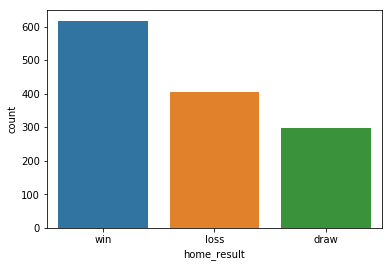

In [3]:
import seaborn as sns
%matplotlib inline
import collections, numpy
sns.countplot(df.home_result)

class clr:
    P = '\033[95m'
    C = '\033[96m'
    DC = '\033[36m'
    B = '\033[94m'
    G = '\033[92m'
    Y = '\033[93m'
    R = '\033[91m'
    BOLD = '\033[1m'
    UL = '\033[4m'
    END = '\033[0m'

print(clr.BOLD + clr.UL + clr.B + 'Home Result of already played matches' + clr.END)
print(clr.BOLD + clr.G + '  the graph showing that home team is more likely to win the match' + clr.END)

### Distribution of Importance1

Importance of match from home team prespective
  the graph showing importance of match from home team prespective distribution


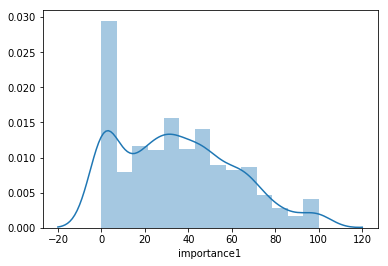

In [4]:
sns.distplot(df.importance1.dropna())

print(clr.BOLD + clr.UL + clr.B + 'Importance of match from home team prespective' + clr.END)
print(clr.BOLD + clr.G + '  the graph showing importance of match from home team prespective distribution' + clr.END)

### Distribution of SPI1

Soccer Power Index (SPI) of home team
  the graph showing Soccer Power Index (SPI) of home team Distribution


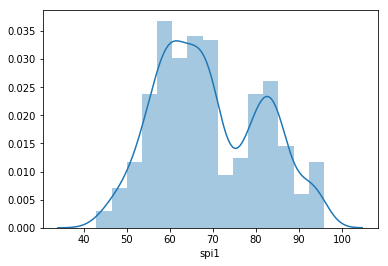

In [5]:
sns.distplot(df.spi1)
print(clr.BOLD + clr.UL + clr.B + 'Soccer Power Index (SPI) of home team' + clr.END)
print(clr.BOLD + clr.G + '  the graph showing Soccer Power Index (SPI) of home team Distribution' + clr.END)

### XG Distribution

Expected Goals (xG) for home team
  the graph showing xG for home team distribution


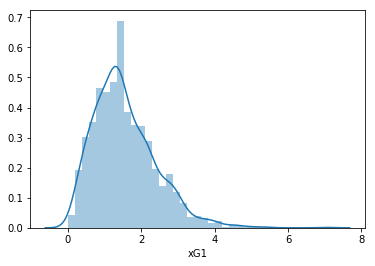

In [6]:
sns.distplot(df.xG1)
print(clr.BOLD + clr.UL + clr.B + 'Expected Goals (xG) for home team' + clr.END)
print(clr.BOLD + clr.G + '  the graph showing xG for home team distribution' + clr.END)

SPI of home team Box Plot
  the graph showing that win probability is directly proportional with SPI


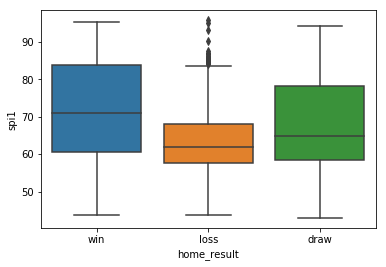

In [7]:
sns.boxplot("home_result", "spi1", data=df)

print(clr.BOLD + clr.UL + clr.B + 'SPI of home team Box Plot' + clr.END)
print(clr.BOLD + clr.G + '  the graph showing that win probability is directly proportional with SPI' + clr.END)

Box Plot of home result vs position
  the graph showing that home team is more likely to win when it has a higher rank


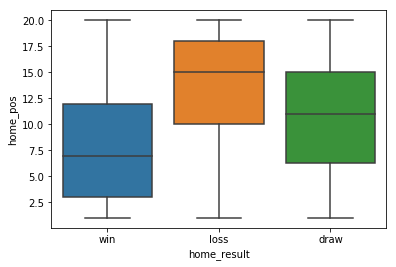

In [8]:
sns.boxplot("home_result", "home_pos", data=df)
print(clr.BOLD + clr.UL + clr.B + 'Box Plot of home result vs position' + clr.END)
print(clr.BOLD + clr.G + '  the graph showing that home team is more likely to win when it has a higher rank' + clr.END)

## Diffrent features relation to th final labels of Win/Lose/Draw

Box Plot of home result vs Importance
  the graph showing that home team is more likely to win when the match is more important


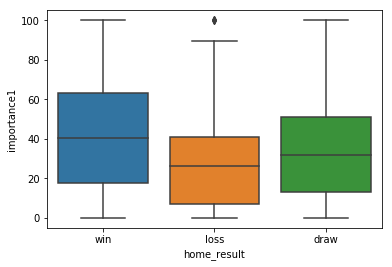

In [9]:
sns.boxplot("home_result", "importance1", data=df)
print(clr.BOLD + clr.UL + clr.B + 'Box Plot of home result vs Importance' + clr.END)
print(clr.BOLD + clr.G + '  the graph showing that home team is more likely to win when the match is more important' + clr.END)

Box Plot of home result vs xG
  the graph showing that home team is more likely to win when the xG is higher


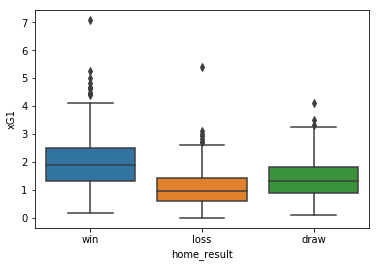

In [10]:
sns.boxplot("home_result", "xG1", data=df)
print(clr.BOLD + clr.UL + clr.B + 'Box Plot of home result vs xG' + clr.END)
print(clr.BOLD + clr.G + '  the graph showing that home team is more likely to win when the xG is higher' + clr.END)

Box Plot of home result vs win%
  the graph showing that home team is more likely to win when the win% gets higher


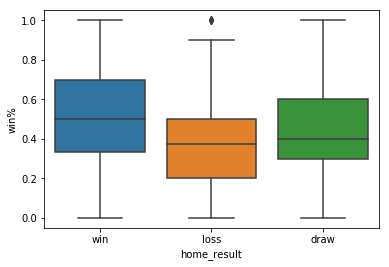

In [11]:
sns.boxplot("home_result", "win%", data=df)
print(clr.BOLD + clr.UL + clr.B + 'Box Plot of home result vs win%' + clr.END)
print(clr.BOLD + clr.G + '  the graph showing that home team is more likely to win when the win% gets higher' + clr.END)

Box Plot of home result vs draw%
  the graph showing that it is hard to predict draw


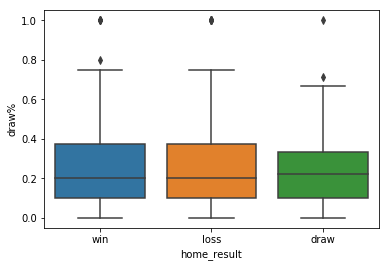

In [12]:
sns.boxplot("home_result", "draw%", data=df)
print(clr.BOLD + clr.UL + clr.B + 'Box Plot of home result vs draw%' + clr.END)
print(clr.BOLD + clr.G + '  the graph showing that it is hard to predict draw' + clr.END)

Box Plot of home result vs loss%
  the graph showing that home team is more likely to lose when the loss% gets higher


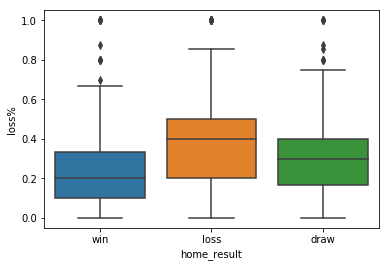

In [13]:
sns.boxplot("home_result", "loss%", data=df)
print(clr.BOLD + clr.UL + clr.B + 'Box Plot of home result vs loss%' + clr.END)
print(clr.BOLD + clr.G + '  the graph showing that home team is more likely to lose when the loss% gets higher' + clr.END)

Box Plot of home result vs form (average points in last 5 matches)
  the graph showing that home team is more likely to win when form gets higher


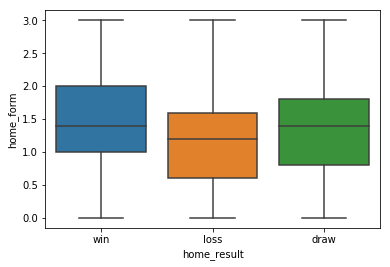

In [14]:
sns.boxplot("home_result", "home_form", data=df)
print(clr.BOLD + clr.UL + clr.B + 'Box Plot of home result vs form (average points in last 5 matches)' + clr.END)
print(clr.BOLD + clr.G + '  the graph showing that home team is more likely to win when form gets higher' + clr.END)

Box Plot of home result vs visitor form
  the graph showing that home team is more likely to lose when visitor form gets higher


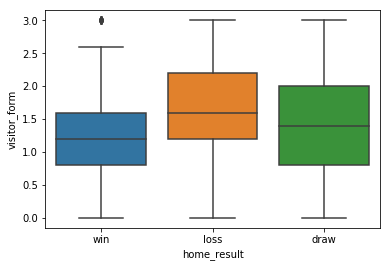

In [15]:
sns.boxplot("home_result", "visitor_form", data=df)
print(clr.BOLD + clr.UL + clr.B + 'Box Plot of home result vs visitor form' + clr.END)
print(clr.BOLD + clr.G + '  the graph showing that home team is more likely to lose when visitor form gets higher' + clr.END)

## Relation between importance and league position and SPI

The Relation Between home Posistion and Importance
  the graph showing that importance of the match increasing when position is high or low 
  and decreasing when position in between


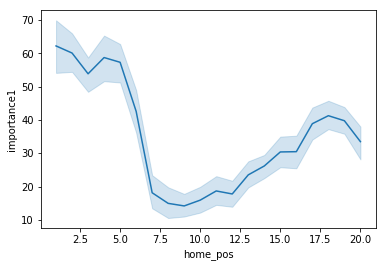

In [16]:
sns.lineplot("home_pos","importance1", data=df)
print(clr.BOLD + clr.UL + clr.B + 'The Relation Between home Posistion and Importance' + clr.END)
print(clr.BOLD + clr.G + '  the graph showing that importance of the match increasing when position is high or low \n  and decreasing when position in between' + clr.END)

The Relation Between visitor Posistion and Importance
  the graph is confirming the previous findings


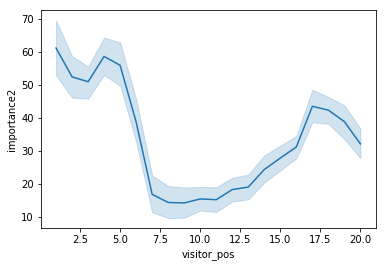

In [17]:
sns.lineplot("visitor_pos", "importance2", data = df)
print(clr.BOLD + clr.UL + clr.B + 'The Relation Between visitor Posistion and Importance' + clr.END)
print(clr.BOLD + clr.G + '  the graph is confirming the previous findings' + clr.END)

Joint plot of Importance and SPI from home team prespective
  the graph showing that matches of teams with low and high SPI get higher importance than
  teams with medium SPI


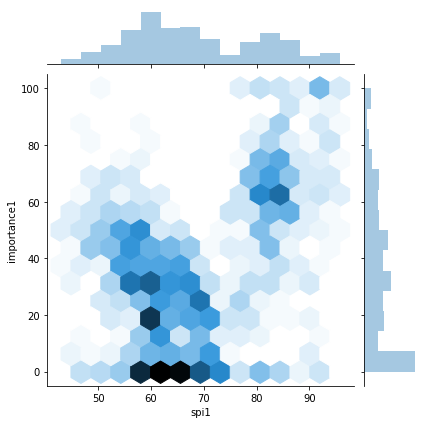

In [18]:
sns.jointplot("spi1", "importance1", data = df, kind="hex")
print(clr.BOLD + clr.UL + clr.B + 'Joint plot of Importance and SPI from home team prespective' + clr.END)
print(clr.BOLD + clr.G + '  the graph showing that matches of teams with low and high SPI get higher importance than\n  teams with medium SPI' + clr.END)

## Relationship between XG, Projected Scores and Real Scores

Joint Plot of xG and score of home team
  the graph showing that home team actual score is close to the expected goals


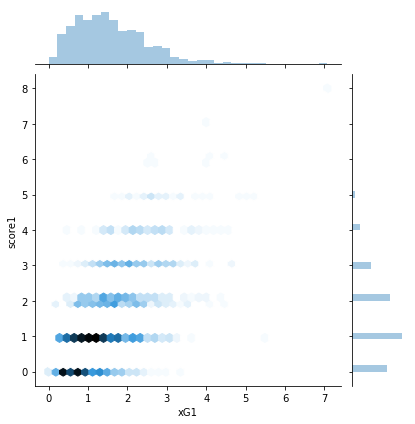

In [19]:
sns.jointplot("xG1", "score1", data = df, kind="hex")
print(clr.BOLD + clr.UL + clr.B + 'Joint Plot of xG and score of home team' + clr.END)
print(clr.BOLD + clr.G + '  the graph showing that home team actual score is close to the expected goals' + clr.END)

Joint Plot of xG and projected score of home team
  the graph showing that home team xG is close to 538 projected score


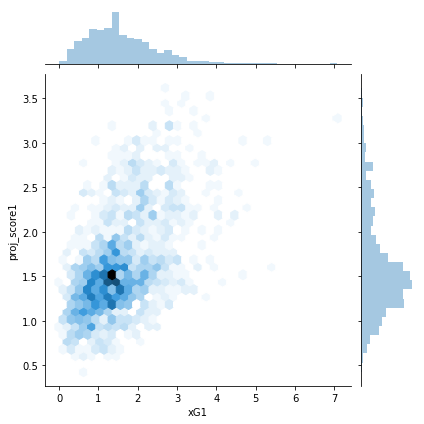

In [20]:
sns.jointplot("xG1", "proj_score1", data = df, kind = 'hex')
print(clr.BOLD + clr.UL + clr.B + 'Joint Plot of xG and projected score of home team' + clr.END)
print(clr.BOLD + clr.G + '  the graph showing that home team xG is close to 538 projected score' + clr.END)

Joint Plot of projected score and actual score of home team
  the graph showing that home team actual score is close to the 538 projected score


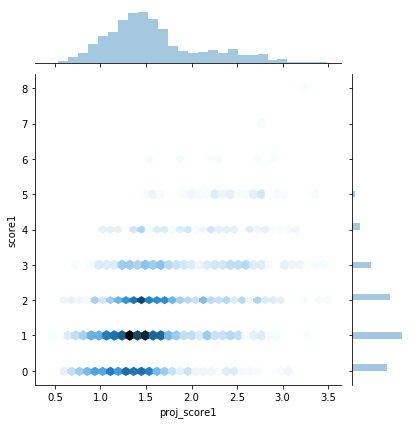

In [21]:
sns.jointplot("proj_score1", "score1", data = df, kind = 'hex')
print(clr.BOLD + clr.UL + clr.B + 'Joint Plot of projected score and actual score of home team' + clr.END)
print(clr.BOLD + clr.G + '  the graph showing that home team actual score is close to the 538 projected score' + clr.END)

Line plot of projected score and xG from home team prespective
  the graph showing that home team xG is close to 538 projected score


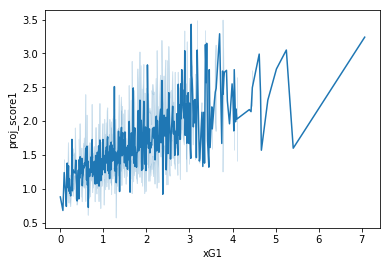

In [22]:
sns.lineplot("xG1", "proj_score1", data = df_played_matches)
print(clr.BOLD + clr.UL + clr.B + 'Line plot of projected score and xG from home team prespective' + clr.END)
print(clr.BOLD + clr.G + '  the graph showing that home team xG is close to 538 projected score' + clr.END)

Line Plot of xG and score of home team
  the graph showing that home team actual score is close to the expected goals


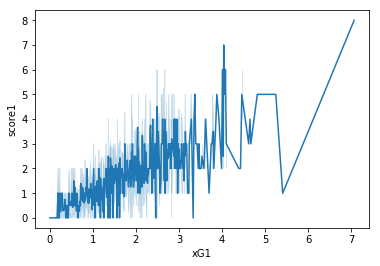

In [23]:
sns.lineplot("xG1", "score1", data = df_played_matches)

print(clr.BOLD + clr.UL + clr.B + 'Line Plot of xG and score of home team' + clr.END)
print(clr.BOLD + clr.G + '  the graph showing that home team actual score is close to the expected goals' + clr.END)

## Pair Plots

Pair Plot Graph
  the graph showing that some features are seperable like position feature


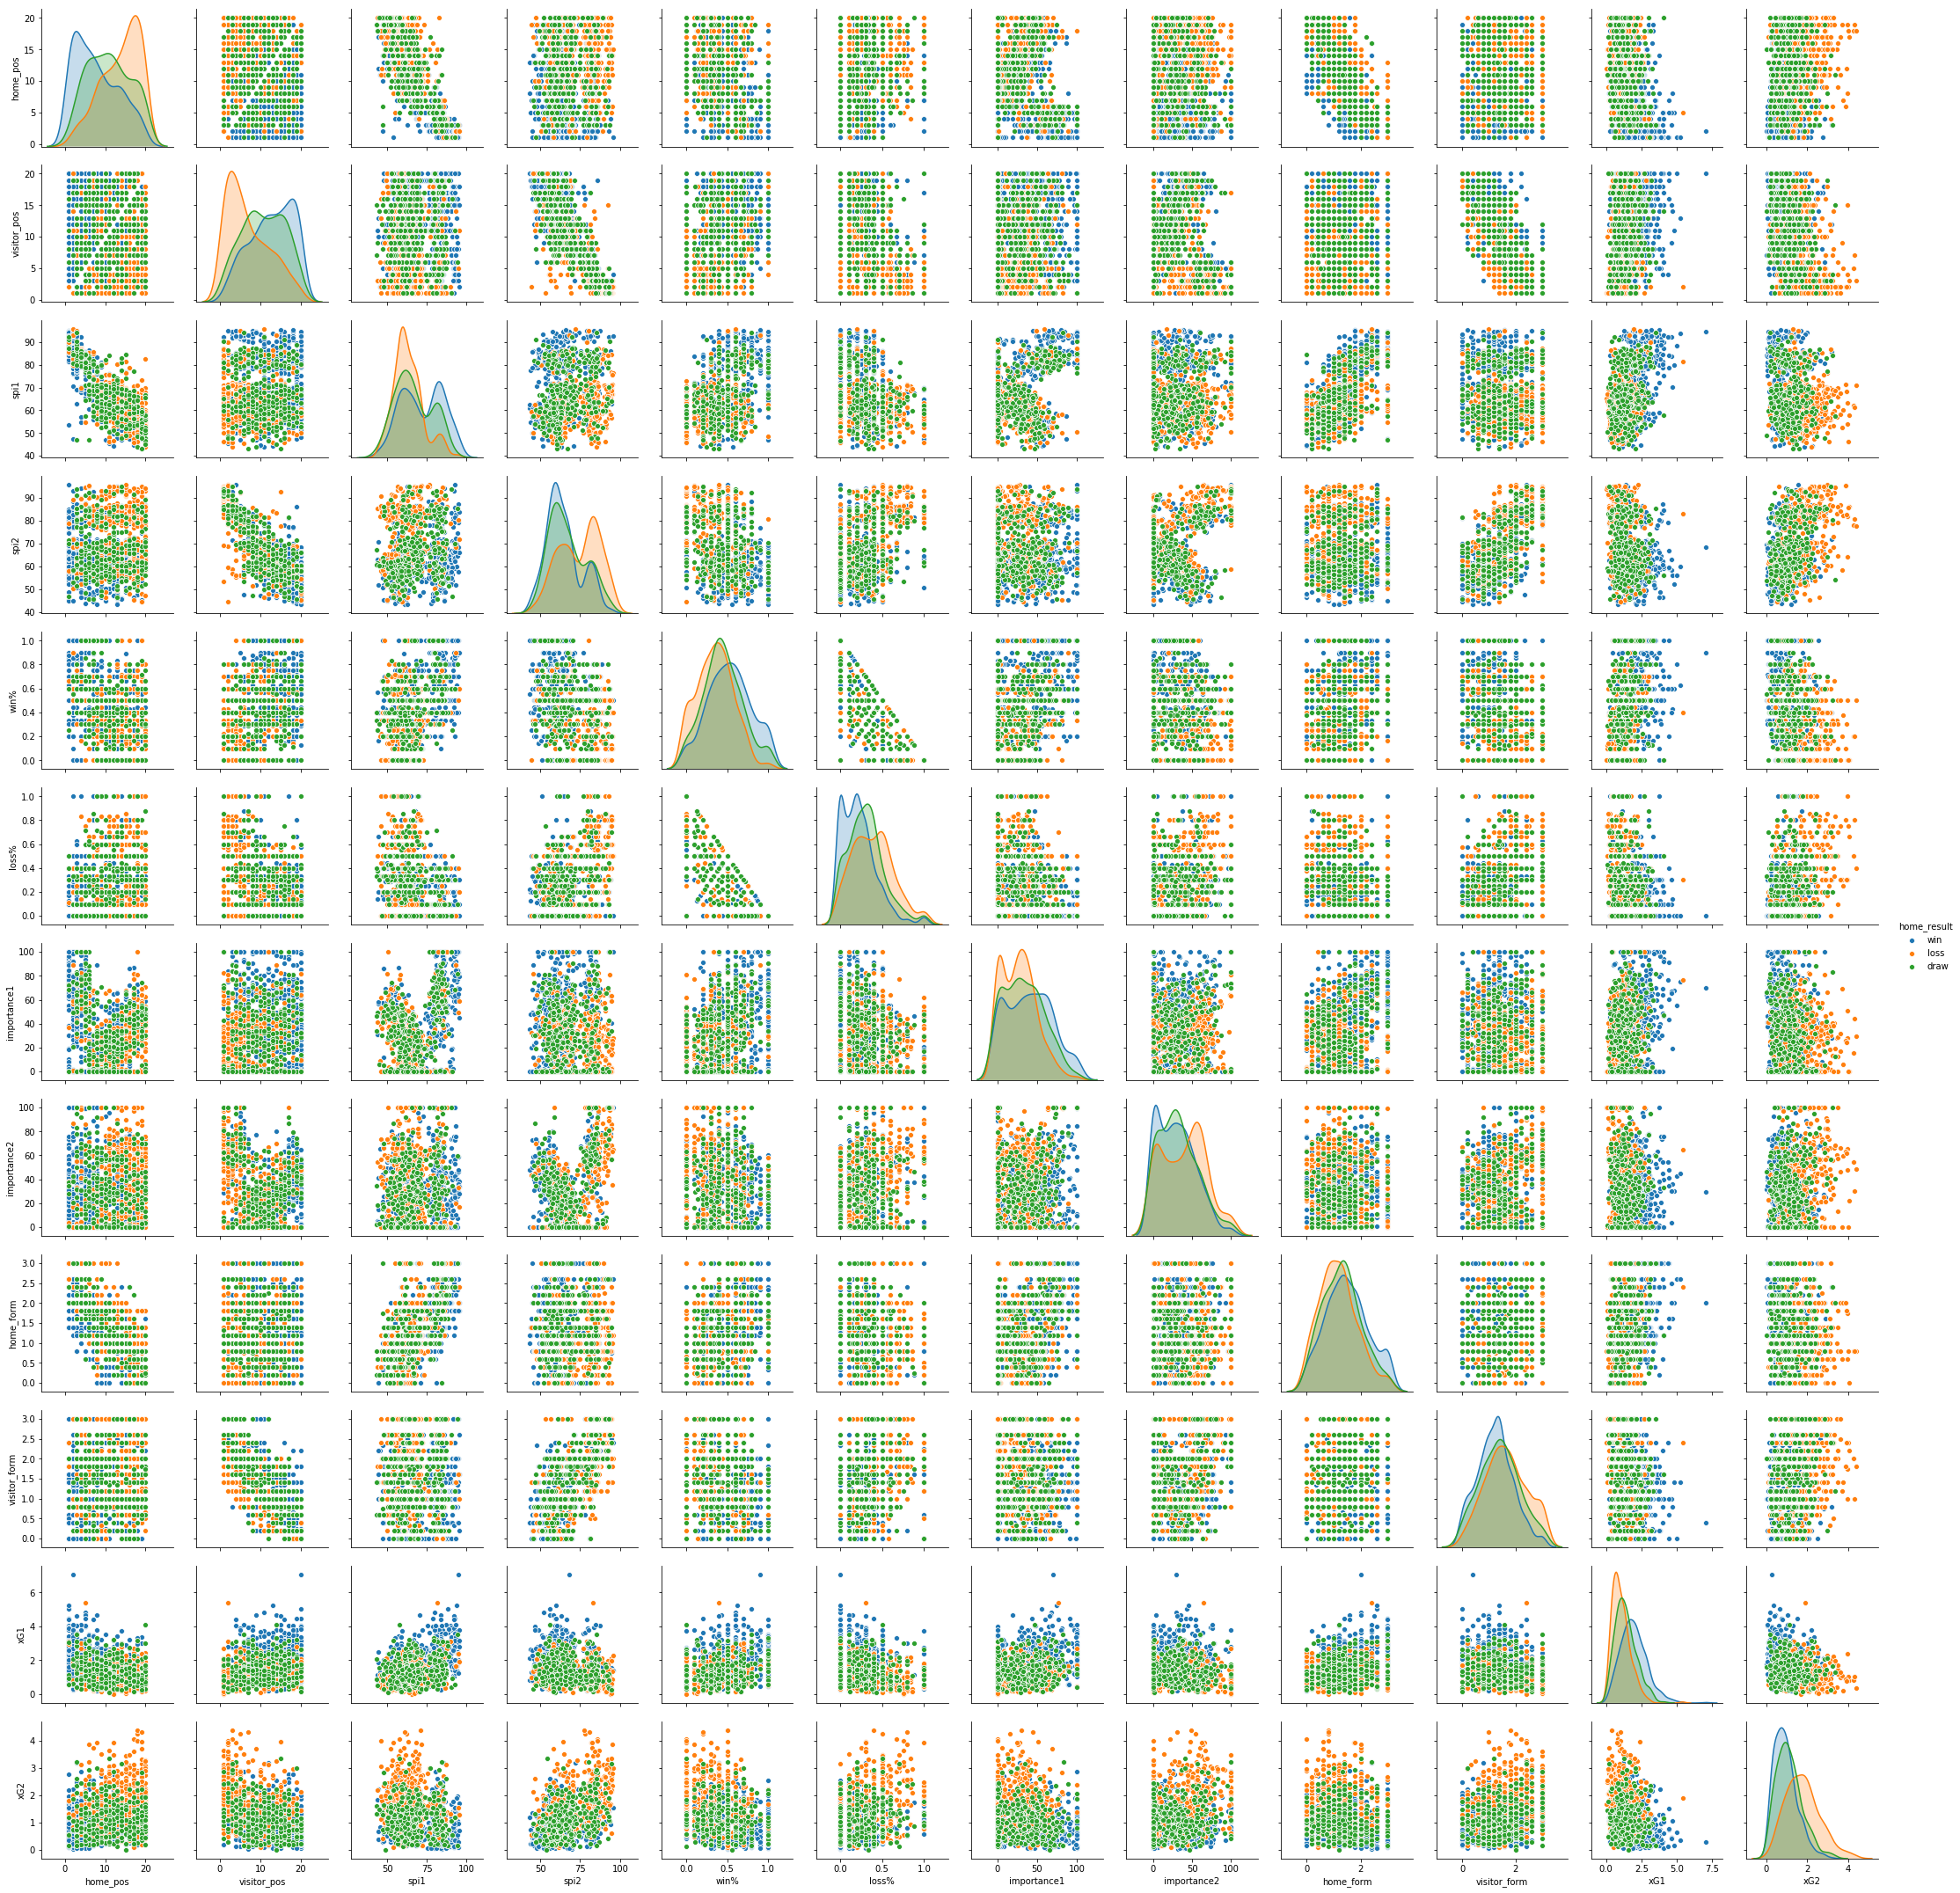

In [24]:
fig = sns.pairplot(data = df_played_matches[['home_pos', 'visitor_pos', 'spi1', 'spi2', 'win%', 'loss%',
       'importance1', 'importance2', 'home_form', 'visitor_form', 'xG1', 'xG2', 'home_result']], hue = "home_result")
fig.savefig("image.png")

print(clr.BOLD + clr.UL + clr.B + 'Pair Plot Graph' + clr.END)
print(clr.BOLD + clr.G + '  the graph showing that some features are seperable like position feature' + clr.END)

# Predicting Importance

Kernel Ridge
Mean Absolute Error: 21.544287420773617
Root of the Mean Square Error 30.86950360507601


Support Vector Regressor
Mean Absolute Error: 12.768116164282523
Root of the Mean Square Error 17.17464625977751


Nu Support Vector Regressor
Mean Absolute Error: 11.864194100087447
Root of the Mean Square Error 15.857654635428204

Line Plot of home position and importance
  the graph showing that our prediction pattern using NuSVR model (blue) is very close to real pattern


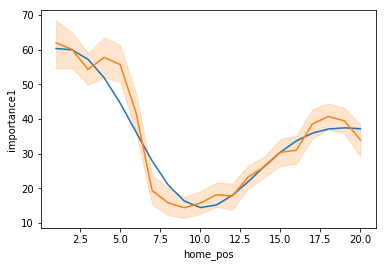

In [4]:
from sklearn import metrics
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
# home teams
training_X = np.asarray(df_played_matches[df_played_matches.Season != 2019][['home_pos']]).reshape(-1, 1)
validation_X = np.asarray(df_played_matches[df_played_matches.Season == 2019][['home_pos']]).reshape(-1, 1)
wanted_X = np.asarray(df.iloc[1320:][['home_pos']]).reshape(-1, 1)

training_y = np.asarray(df_played_matches[df_played_matches.Season != 2019].importance1).reshape(-1, 1)
validation_y = np.asarray(df_played_matches[df_played_matches.Season == 2019].importance1).reshape(-1, 1)

# Kerner Ridge Regression
Importance_model = KernelRidge()
Importance_model.fit(training_X, training_y)

predicted_validation_y = Importance_model.predict(validation_X)
print("Kernel Ridge")
print(f"Mean Absolute Error: {metrics.mean_absolute_error(validation_y, predicted_validation_y)}")
mse = np.sqrt(metrics.mean_squared_error(validation_y, predicted_validation_y))
print(f"Root of the Mean Square Error {mse}")


# Support Vector Regression
Importance_model = SVR()
Importance_model.fit(training_X, training_y)

predicted_validation_y = Importance_model.predict(validation_X)
print("\n")
print("Support Vector Regressor")
print(f"Mean Absolute Error: {metrics.mean_absolute_error(validation_y, predicted_validation_y)}")
mse = np.sqrt(metrics.mean_squared_error(validation_y, predicted_validation_y))
print(f"Root of the Mean Square Error {mse}")

from sklearn.svm import NuSVR
Importance_model = NuSVR()
Importance_model.fit(training_X, training_y)
predicted_validation_y = Importance_model.predict(validation_X)
print("\n")
print("Nu Support Vector Regressor")
print(f"Mean Absolute Error: {metrics.mean_absolute_error(validation_y, predicted_validation_y)}")
mse = np.sqrt(metrics.mean_squared_error(validation_y, predicted_validation_y))
print(f"Root of the Mean Square Error {mse}")


# we chose NuSVR
training_X = np.vstack((training_X, validation_X))
training_y = np.vstack((training_y, validation_y))

Importance1_model = NuSVR()
Importance1_model.fit(training_X, training_y)

predicted_y = Importance1_model.predict(wanted_X)
df.iloc[1320:,-9] = predicted_y





#visitor teams
training_X = np.asarray(df_played_matches[df_played_matches.Season != 2019][['visitor_pos']]).reshape(-1, 1)
validation_X = np.asarray(df_played_matches[df_played_matches.Season == 2019][['visitor_pos']]).reshape(-1, 1)
wanted_X = np.asarray(df.iloc[1320:][['visitor_pos']]).reshape(-1, 1)

training_y = np.asarray(df_played_matches[df_played_matches.Season != 2019].importance2).reshape(-1, 1)
validation_y = np.asarray(df_played_matches[df_played_matches.Season == 2019].importance2).reshape(-1, 1)


#We chosose SVR for importance 2
training_X = np.vstack((training_X, validation_X))
training_y = np.vstack((training_y, validation_y))

Importance2_model = NuSVR()
Importance2_model.fit(training_X, training_y)

predicted_y = Importance2_model.predict(wanted_X)
df.iloc[1320:,-8] = predicted_y


sns.lineplot("home_pos","importance1", data=df.iloc[1320:])

sns.lineplot("home_pos","importance1", data=df)

print(clr.BOLD + clr.UL + clr.B + '\nLine Plot of home position and importance' + clr.END)
print(clr.BOLD + clr.G + '  the graph showing that our prediction pattern using NuSVR model (blue) is very close to real pattern' + clr.END)

# Logistic Regression One versus all test run

In [5]:
import statsmodels.discrete.discrete_model as ds
import scipy.stats as st
from statsmodels.tools import add_constant as add_constant
df_win_lose = df_played_matches[['home_pos', 'visitor_pos', 'spi1', 'spi2', 'loss%',
       'importance1', 'importance2', 'home_form', 'visitor_form', 'xG1', 'xG2', 'home_result']].copy()

from sklearn.preprocessing import LabelEncoder, RobustScaler
enc = LabelEncoder()

label_encoder = enc.fit(df_win_lose.home_result)
y = label_encoder.transform(df_win_lose.home_result)
df_win_lose["home_result"] = y
scaler = RobustScaler()
scaler.fit(df_win_lose)
X_train = scaler.transform(df_win_lose)



df_win_lose = df_win_lose.astype(float)
df_constant = add_constant(df_win_lose)

cols=df_win_lose.columns[:-1]
df_win_lose["home_result"] = y
model= ds.MNLogit(df_win_lose.home_result,df_constant[cols])
result=model.fit()


print(clr.BOLD + clr.UL + clr.B + '\nLogistic Regression Summary' + clr.END)
print(clr.BOLD + clr.G + '  Refering to 0:draw, 1:win, 2:loss, the logistic regression showing that it is difficult to \n  differentiate between draw and loss (P-Value > 0.05%) but P-Value is < 0.05% in case of\n  draw and win' + clr.END)

result.summary()

#draw win loss

Optimization terminated successfully.
         Current function value: 0.758145
         Iterations 7

Logistic Regression Summary
  Refering to 0:draw, 1:win, 2:loss, the logistic regression showing that it is difficult to 
  differentiate between draw and loss (P-Value > 0.05%) but P-Value is < 0.05% in case of
  draw and win


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:            home_result   No. Observations:                 1320
Model:                        MNLogit   Df Residuals:                     1298
Method:                           MLE   Df Model:                           20
Date:                Tue, 21 Jan 2020   Pseudo R-squ.:                  0.2807
Time:                        08:39:43   Log-Likelihood:                -1000.8
converged:                       True   LL-Null:                       -1391.3
Covariance Type:            nonrobust   LLR p-value:                1.512e-152
=================================================================================
home_result=1       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
home_pos          0.1527      0.024      6.367      0.000       0.106       0.200
visitor_pos      -0.1775      0.026     -6.940      0.000      -0.228      -0.127
spi1              0.0181      0.012      1.560      0.119      -0.005       0.041
spi2             -0.0192      0.012     -1.580      0.114      -0.043       0.005
loss%            -0.5098      0.455     -1.121      0.262      -1.401       0.381
importance1      -0.0133      0.004     -3.262      0.001      -0.021      -0.005
importance2       0.0069      0.004      1.850      0.064      -0.000       0.014
home_form         0.4733      0.169      2.801      0.005       0.142       0.805
visitor_form     -0.6178      0.173     -3.564      0.000      -0.957      -0.278
xG1              -0.4258      0.137     -3.097      0.002      -0.695      -0.156
xG2               0.9807      0.140      7.013      0.000       0.707       1.255
---------------------------------------------------------------------------------
home_result=2       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
home_pos         -0.1427      0.022     -6.599      0.000      -0.185      -0.100
visitor_pos       0.0996      0.021      4.759      0.000       0.059       0.141
spi1             -0.0242      0.010     -2.380      0.017      -0.044      -0.004
spi2              0.0393      0.011      3.680      0.000       0.018       0.060
loss%            -0.6613      0.411     -1.608      0.108      -1.467       0.145
importance1       0.0062      0.003      1.887      0.059      -0.000       0.013
importance2      -0.0061      0.003     -1.827      0.068      -0.013       0.000
home_form        -0.4864      0.149     -3.270      0.001      -0.778      -0.195
visitor_form      0.0101      0.152      0.067      0.947      -0.288       0.308
xG1               0.6714      0.107      6.273      0.000       0.462       0.881
xG2              -0.3085      0.137     -2.246      0.025      -0.578      -0.039
=================================================================================
"""

# Multinomial logistic without oversampling or normalization

In [8]:
from sklearn.linear_model import LogisticRegression

df_train = df_played_matches[['home_pos', 'visitor_pos', 'spi1', 'spi2', 'loss%',  'importance1', 'importance2', 'xG1', 'xG2', 'home_result']]

df_test = df.iloc[1320:][['home_pos', 'visitor_pos', 'spi1', 'spi2', 'loss%', 'importance1', 'importance2', 'xG1', 'xG2', 'home_result']]

X_train = df_train[['home_pos', 'visitor_pos', 'spi1', 'spi2', 'loss%', 'importance1', 'importance2', 'xG1', 'xG2']]
y_train = df_train['home_result']
X_test = df_test[['home_pos', 'visitor_pos', 'spi1', 'spi2', 'loss%', 'importance1', 'importance2', 'xG1', 'xG2']]




classifier = LogisticRegression(max_iter=2000, multi_class = 'multinomial', solver = 'saga',penalty='elasticnet',l1_ratio = .5)
classifier.fit(X_train, y_train)
t = classifier.predict_proba(X_test)
classifier.classes_
df_predictions = df.iloc[1320:][['Date','Season','Round','home','visitor','proj_score1','proj_score2']]
df_predictions['win_prob'] = t[:,2]
df_predictions['draw_prob'] = t[:,0]
df_predictions['loss_prob'] = t[:,1]

df_2019_played = df[df.Season== 2019][['Date','Season','Round','home','visitor','proj_score1','proj_score2', 'home_result']].dropna()

def league_points_calculator(row):
    if row['home'] == i:
        return 3*row["win_prob"] + 1*row["draw_prob"]
    else:
        return 3*row["loss_prob"] + 1*row["draw_prob"]

def convert_to_percent(row):
    if row.home_result == "win":
        win = 1
        draw, loss = 0, 0
    elif row.home_result == "draw":
        draw = 1
        win,loss = 0, 0
    else:
        loss = 1
        win, draw = 0, 0
    return win, draw, loss

df_2019_played["win_prob"], df_2019_played["draw_prob"], df_2019_played["loss_prob"] =  zip(*df_2019_played.apply(convert_to_percent, axis = 1))

df_2019_predictions = pd.concat([df_2019_played, df_predictions], sort = False).reset_index()
del df_2019_predictions["home_result"]

tables = []
for i in teams_2019:
    cursor = df_2019_predictions[((df_2019_predictions.home == i)|(df_2019_predictions.visitor == i))][["Date", "Season", "Round", "home", "visitor", "win_prob", "draw_prob", "loss_prob"]]
    cursor['points'] = cursor.apply(league_points_calculator, axis = 1)
    tables.append((cursor[["Round","points"]].rename(columns={"points": i}).set_index('Round').T))

cursor = pd.concat(tables).reset_index()
cursor = cursor.set_index('index')
premier_league_table = cursor.sum(axis=1).sort_values(ascending = False).to_frame('total_pts').round(0).reset_index()


premier_league_table

,index,total_pts
0,Liverpool,97.0
1,Manchester City,87.0
2,Leicester City,83.0
3,Chelsea,76.0
4,Manchester United,61.0
5,Tottenham Hotspur,61.0
6,Wolverhampton Wanderers,59.0
7,Crystal Palace,52.0
8,Sheffield United,50.0
9,Arsenal,50.0


## We Can See that the model is very biased

(array(['draw', 'loss', 'win'], dtype=object), array([  3,  84, 113]))


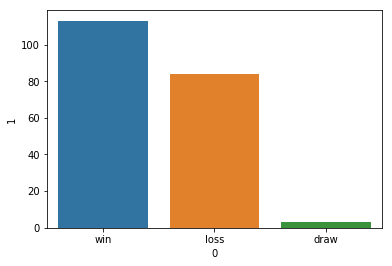

In [9]:
zzzz= np.unique(classifier.predict(X_test), return_counts=True)
dff = pd.DataFrame(zzzz, columns=["win","loss","draw"]).transpose().sort_values(by=1, ascending = False)
print(np.unique(classifier.predict(X_test), return_counts=True))
sns.barplot(x=0,y=1,data=dff)

# Logistic regression with SMOTE and normalization

In [10]:
from math import floor
from sklearn.linear_model import LogisticRegression
df_train = df_played_matches[['home_pos', 'visitor_pos', 'spi1', 'spi2', 'loss%', 'home_form', 'visitor_form', 'importance1', 'importance2', 'xG1', 'xG2', 'home_result']]
df_test = df.iloc[1320:][['Round', 'home_pos', 'visitor_pos', 'spi1', 'spi2', 'loss%', 'home_form', 'visitor_form', 'importance1', 'importance2', 'xG1', 'xG2']]
X_train = df_train[['home_pos', 'visitor_pos', 'spi1', 'spi2', 'loss%', 'home_form', 'visitor_form', 'importance1', 'importance2', 'xG1', 'xG2']]
y_train = df_train['home_result']

from imblearn.over_sampling import SVMSMOTE
SVMSMOTE = SVMSMOTE()
columns = X_train.columns
up_sampled_X,up_sampled_y=SVMSMOTE.fit_sample(X_train, y_train)
up_sampled_X = pd.DataFrame(data=up_sampled_X,columns=columns )
up_sampled_y= pd.DataFrame(data=up_sampled_y,columns=['home_result'])
from sklearn import preprocessing
scaler = preprocessing.RobustScaler()
scaler.fit(up_sampled_X)
X_train = scaler.transform(up_sampled_X)

df_copy = df[df.Season == 2019].copy()

df_copy["win_prob"], df_copy["draw_prob"], df_copy["loss_prob"] =  zip(*df_copy.apply(convert_to_percent, axis = 1))
df_copy.to_csv("f.csv")
def points_adder(table):
    for i in range(17,39):
        table[i] = table[i] + table[i-1]
    return table
      
classifier = LogisticRegression(max_iter=300, multi_class = 'multinomial', solver = 'saga',penalty='elasticnet',l1_ratio = .5)
classifier.fit(X_train, up_sampled_y)

def form_calculator_(row, df, home):
    if home:
        x = row.home
    else:
        x = row.visitor
    number_of_matches = 5
    matches = df[((df.home == x) | (df.visitor == x)) & ((df.Season == row.Season) &(df.Round < row.Round))].tail(number_of_matches)[["home", "visitor", "win_prob", "draw_prob", "loss_prob"]]
    number_of_matches = matches["home"].count()
    if number_of_matches == 0:
        return (7/5)
    win = []
    draw = []
    for i in range(number_of_matches):
        row = matches.iloc[i]
        if row.home == x:
            win.append(float(row.win_prob))
            draw.append(float(row.draw_prob))
        else:
            win.append(float(row.loss_prob))
            draw.append(float(row.draw_prob))
    return float(sum(win)*3 + sum(draw)*1)/float(number_of_matches)

        

start_test = 0
start_index = 1320-1140
df_copy.iloc[(start_index):,-3] = 0
df_copy.iloc[(start_index):,-2] = 0
df_copy.iloc[(start_index):,-1] = 0
start_round = int(df_test.Round.iloc[0])
round_ = start_round


for ii in range(start_round,39):
    X_test = df_test[df_test.Round == ii][['home_pos', 'visitor_pos', 'spi1', 'spi2', 'loss%', 'home_form', 'visitor_form', 'importance1', 'importance2', 'xG1', 'xG2']]
    X_test = scaler.transform(X_test)
    t = classifier.predict_proba(X_test)
    df_copy.iloc[(start_index):(start_index+10),-3] = t[:,2]
    df_copy.iloc[(start_index):(start_index+10),-2] = t[:,0]
    df_copy.iloc[(start_index):(start_index+10),-1] = t[:,1]
    df_copy["home_form"] = df_copy.apply(form_calculator_, args = (df_copy, True), axis=1)
    df_copy["visitor_form"] = df_copy.apply(form_calculator_,args = (df_copy, False),axis=1)
    tables = []
    for i in teams_2019:
        cursor = df_copy[((df_copy.home == i)|(df_copy.visitor == i))][["Date", "Season", "Round", "home", "visitor", "win_prob", "draw_prob", "loss_prob"]]
        cursor['points'] = cursor.apply(league_points_calculator, axis = 1)
        tables.append((cursor[["Round","points"]].rename(columns={"points": i}).set_index('Round').T))

    cursor = pd.concat(tables).reset_index()
    pos_2019 = points_adder(cursor)
    for i in range(16,39):
        pos_2019 = pos_2019.sort_values(by=[i],ascending=False)
        pos_2019[i] = list(range(1,21))
    iterator = [((2019, pos_2019, 17, 39, True), (2019, pos_2019, 17, 39, False))]
    for i in iterator:
        df_copy['home_pos'] = df_copy.apply(positionator, args=i[0], axis = 1)
        df_copy['visitor_pos'] = df_copy.apply(positionator, args=i[1], axis = 1)
    X_test = np.asarray(df_copy[df_copy.Round == ii][['home_pos', 'visitor_pos', 'spi1', 'spi2', 'loss%', 'home_form', 'visitor_form', 'importance1', 'importance2', 'xG1', 'xG2']])
    df_copy.iloc[(start_index):(start_index+10),14] = Importance1_model.predict(X_test[:,0].reshape(-1, 1))
    df_copy.iloc[(start_index):(start_index+10),15] = Importance2_model.predict(X_test[:,1].reshape(-1, 1))
    df_test.iloc[(start_test):(start_test+10):,6:9] = df_copy.iloc[(start_index):(start_index+10):,12:15]
    df_test.iloc[(start_test):(start_test+10):,1:2] = df_copy.iloc[(start_index):(start_index+10):,5:6]
    start_index += 10
    start_test += 10
    print(f"{floor((start_index-1320+1140)*100/(1519-1320))}% done.")

Using TensorFlow backend.


5% done.
10% done.
15% done.
20% done.
25% done.
30% done.
35% done.
40% done.
45% done.
50% done.
55% done.
60% done.
65% done.
70% done.
75% done.
80% done.
85% done.
90% done.
95% done.
100% done.


In [11]:
df = pd.concat((df.iloc[0:1140],df_copy[['Date', 'Season', 'Round', 'home', 'visitor', 'home_pos', 'visitor_pos', 'spi1', 'spi2', 'win%', 'draw%', 'loss%', 'home_form', 'visitor_form', 'importance1', 'importance2', 'xG1', 'xG2', 'proj_score1', 'proj_score2', 'home_result', 'score1', 'score2']]))
df.to_csv("final_data.csv")

In [12]:
wanted_X = np.asarray(df.iloc[1320:][['home_pos']]).reshape(-1, 1)
predicted_y = Importance1_model.predict(wanted_X)
df.iloc[1320:,-9] = predicted_y
wanted_X = np.asarray(df.iloc[1320:][['visitor_pos']]).reshape(-1, 1)
predicted_y = Importance2_model.predict(wanted_X)
df.iloc[1320:,-8] = predicted_y

X_test = scaler.transform(df.iloc[1320:][['home_pos', 'visitor_pos', 'spi1', 'spi2', 'loss%', 'home_form', 'visitor_form', 'importance1', 'importance2', 'xG1', 'xG2']])
t = classifier.predict_proba(X_test)
df_predictions = df.iloc[1320:][['Date','Season','Round','home','visitor','proj_score1','proj_score2']]
df_predictions['win_prob'] = t[:,2]
df_predictions['draw_prob'] = t[:,0]
df_predictions['loss_prob'] = t[:,1]

df_2019_played = df[df.Season == 2019][['Date','Season','Round','home','visitor','proj_score1','proj_score2', 'home_result']].dropna()

df_2019_played["win_prob"], df_2019_played["draw_prob"], df_2019_played["loss_prob"] =  zip(*df_2019_played.apply(convert_to_percent, axis = 1))

df_2019_predictions = pd.concat([df_2019_played, df_predictions], sort = False).reset_index()
del df_2019_predictions["home_result"]

tables = []
for i in teams_2019:
    cursor = df_2019_predictions[((df_2019_predictions.home == i)|(df_2019_predictions.visitor == i))][["Date", "Season", "Round", "home", "visitor", "win_prob", "draw_prob", "loss_prob"]]
    cursor['points'] = cursor.apply(league_points_calculator, axis = 1)
    tables.append((cursor[["Round","points"]].rename(columns={"points": i}).set_index('Round').T))

cursor = pd.concat(tables).reset_index()
cursor = cursor.set_index('index')
premier_league_table = cursor.sum(axis=1).sort_values(ascending = False).to_frame('total_pts').round(0).reset_index()

print(np.unique(classifier.predict(X_test), return_counts=True))
premier_league_table


(array(['draw', 'loss', 'win'], dtype=object), array([66, 68, 66]))


,index,total_pts
0,Liverpool,99.0
1,Manchester City,88.0
2,Leicester City,80.0
3,Chelsea,72.0
4,Tottenham Hotspur,63.0
5,Manchester United,57.0
6,Crystal Palace,55.0
7,Wolverhampton Wanderers,54.0
8,Sheffield United,51.0
9,Everton,47.0


## In this model the bias is gone

(array(['draw', 'loss', 'win'], dtype=object), array([66, 68, 66]))


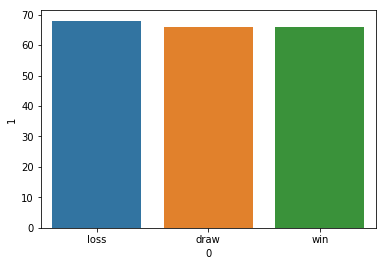

In [13]:
zzzz= np.unique(classifier.predict(X_test), return_counts=True)
dff = pd.DataFrame(zzzz, columns=["win","loss","draw"]).transpose().sort_values(by=1, ascending = False)
print(np.unique(classifier.predict(X_test), return_counts=True))
sns.barplot(x=0,y=1,data=dff)

Result excluded: draw
Area under curve = 0.9206140350877193


Result excluded: win
Area under curve = 0.7253787878787878


Result excluded: loss
Area under curve = 0.8232655502392344




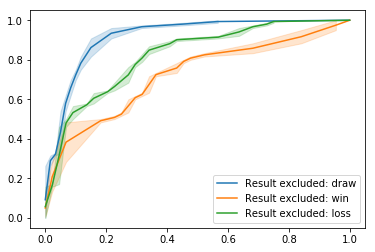

In [14]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
results_to_exclude = ["draw", "win", "loss"]
y = []
auc = []
fpr = []
fnr = []
count = 0
for i in results_to_exclude:
    df_train = df_played_matches[(df_played_matches.Season != 2019) & (df_played_matches.home_result != i)][['home_pos', 'visitor_pos', 'spi1', 'spi2', 'win%', 'loss%', 'draw%', 'importance1', 'importance2', 'xG1', 'xG2', 'home_result']]
    df_test = df[(df.Season == 2019) & (df.home_result != i)][['home_pos', 'visitor_pos', 'spi1', 'spi2', 'win%', 'loss%', 'importance1', 'importance2', 'xG1', 'xG2', 'home_result']].dropna()
    X_train = df_train[['home_pos', 'visitor_pos', 'spi1', 'spi2', 'win%', 'loss%', 'importance1', 'importance2', 'xG1', 'xG2']]
    y_train = df_train['home_result']
    df_predictions = df.iloc[1320:][['Date','Season','Round','home','visitor','proj_score1','proj_score2']]

    X_test = df_test[['home_pos', 'visitor_pos', 'spi1', 'spi2', 'win%', 'loss%', 'importance1', 'importance2', 'xG1', 'xG2']]
    y_test = df_test['home_result']

    from imblearn.over_sampling import SVMSMOTE
    SVMSMOTE = SVMSMOTE()
    columns = X_train.columns
    up_sampled_X,up_sampled_y=SVMSMOTE.fit_sample(X_train, y_train)
    up_sampled_X = pd.DataFrame(data=up_sampled_X,columns=columns )
    up_sampled_y= pd.DataFrame(data=up_sampled_y,columns=['home_result'])

    scaler = preprocessing.RobustScaler()
    scaler.fit(up_sampled_X)
    X_train = scaler.transform(up_sampled_X)
    X_test = scaler.transform(X_test)

    classifier = LogisticRegression(max_iter=10000, solver='lbfgs')
    classifier.fit(X_train, up_sampled_y)
    t = classifier.predict_proba(X_test)[:, 1]

    auc_ = roc_auc_score(y_test, t)
    auc.append(auc_)
    enc = LabelEncoder()
    label_encoder = enc.fit(y_test)
    y_ = label_encoder.transform(y_test)
    y.append(y_)
    false_positive_rate, true_positive_rate, _ = roc_curve(y_, t)
    fpr.append(false_positive_rate)
    fnr.append(true_positive_rate)
    count +=1

for i in range(0,3):
    print(f"Result excluded: {results_to_exclude[i]}")
    print(f"Area under curve = {auc[i]}")
    print("\n")
    sns.lineplot(fpr[i], fnr[i], label = f"Result excluded: {results_to_exclude[i]}")

# ROC curve for Logistic Regression with SMOTE

Logistic Regression Results


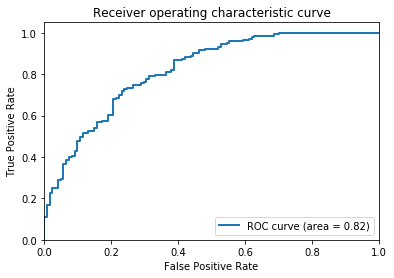

In [34]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
def plot_roc_curve(classifier):
    classifier = OneVsRestClassifier(classifier)
    count = 0
    Data = df_played_matches[['home_pos', 'visitor_pos', 'spi1', 'spi2', 'draw%', 'home_form', 'visitor_form', 'importance1', 'importance2', 'xG1', 'xG2']]
    Target = df_played_matches['home_result']
    y = np.asarray(Target)
    enc = LabelEncoder()
    label_encoder = enc.fit(y)
    y = label_encoder.transform(y)
    X = np.asarray(Data)
    n_classes = 3
    n_samples, n_features = X.shape
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,random_state=5)
    from imblearn.over_sampling import SVMSMOTE
    SVMSMOTE = SVMSMOTE()
    columns = Data.columns
    up_sampled_X,up_sampled_y=SVMSMOTE.fit_sample(X_train, y_train)
    up_sampled_X = pd.DataFrame(data=up_sampled_X,columns=columns )
    up_sampled_y= pd.DataFrame(data=up_sampled_y,columns=['home_result'])
    
    scaler = RobustScaler()
    scaler.fit(up_sampled_X)
    X_train = scaler.transform(up_sampled_X)
    X_test = scaler.transform(X_test)
    
    y_train = label_binarize(np.asarray(up_sampled_y), classes=[0, 1, 2])
    y_test = label_binarize(np.asarray(y_test), classes=[0, 1, 2])
    y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    plt.figure()
    lw = 2
    plt.plot(fpr[2], tpr[2],
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    plt.show()



classifier = LogisticRegression(max_iter=10000, solver='lbfgs')
print("Logistic Regression Results")
plot_roc_curve(classifier)

# Predicting the first half of the premier league for validation

In [35]:
df_train = df_played_matches[(df_played_matches.Season != 2019)][['home_pos', 'visitor_pos', 'spi1', 'spi2', 'loss%', 'importance1', 'importance2', 'home_form', 'visitor_form', 'xG1','xG2', 'home_result']]
df_test = df_played_matches[(df_played_matches.Season == 2019)][['home_pos', 'visitor_pos', 'spi1', 'spi2', 'loss%', 'importance1', 'importance2', 'home_form', 'visitor_form', 'xG1', 'xG2', 'home_result']].dropna()
X_train = df_train[['home_pos', 'visitor_pos', 'spi1', 'spi2', 'loss%', 'importance1','importance2', 'home_form', 'visitor_form', 'xG1', 'xG2']]
y_train = df_train['home_result']
X_test = df_test[['home_pos', 'visitor_pos', 'spi1', 'spi2', 'loss%', 'importance1','importance2', 'home_form', 'visitor_form', 'xG1', 'xG2']]
y_test = df_test['home_result']


from imblearn.over_sampling import SVMSMOTE
SVMSMOTE = SVMSMOTE()
columns = X_train.columns
up_sampled_X,up_sampled_y=SVMSMOTE.fit_sample(X_train, y_train)
up_sampled_X = pd.DataFrame(data=up_sampled_X,columns=columns )
up_sampled_y= pd.DataFrame(data=up_sampled_y,columns=['home_result'])



from sklearn import preprocessing
scaler = RobustScaler()
scaler.fit(up_sampled_X)
X_train = scaler.transform(up_sampled_X)
X_test = scaler.transform(X_test)


classifier = LogisticRegression(max_iter=10000, multi_class = 'multinomial', solver = 'saga',penalty='elasticnet',l1_ratio = .95)
classifier.fit(X_train, up_sampled_y)
y = classifier.predict_proba(X_test)
df_predictions.shape

df_predictions =  df[(df.Season == 2019)].dropna()[['Date','Season','Round','home','visitor','proj_score1','proj_score2']]

df_predictions['win_prob'] = y[:,2]
df_predictions['draw_prob'] = y[:,0]
df_predictions['loss_prob'] = y[:,1]

df_2019_played = df[df.Season == 2019].dropna()[['Date','Season','Round','home','visitor','proj_score1','proj_score2', 'home_result']].dropna()

df_2019_played["win_prob"], df_2019_played["draw_prob"], df_2019_played["loss_prob"] =  zip(*df_2019_played.apply(convert_to_percent, axis = 1))

df_2019_predictions = df_2019_played
del df_2019_predictions["home_result"]

tables = []
for i in teams_2019:
    cursor = df_2019_predictions[((df_2019_predictions.home == i)|(df_2019_predictions.visitor == i))][["Date", "Season", "Round", "home", "visitor", "win_prob", "draw_prob", "loss_prob"]]
    cursor['points'] = cursor.apply(league_points_calculator, axis = 1)
    tables.append((cursor[["Round","points"]].rename(columns={"points": i}).set_index('Round').T))

cursor = pd.concat(tables).reset_index()
cursor = cursor.set_index('index')
premier_league_table = cursor.sum(axis=1).sort_values(ascending = False).to_frame('total_pts').round(0).reset_index()

premier_league_table

,index,total_pts
0,Liverpool,52
1,Leicester City,39
2,Manchester City,38
3,Chelsea,32
4,Wolverhampton Wanderers,28
5,Tottenham Hotspur,27
6,Crystal Palace,26
7,Sheffield United,25
8,Burnley,24
9,Manchester United,24


![Figure 1-1](pic.png "Figure 1-1")

# Using Dimensionality Reduction by PCA before Clustering

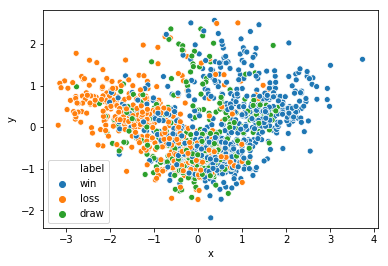

In [36]:
from sklearn.decomposition import PCA
df_train = df_played_matches[(df_played_matches.Season != 2019) & (df_played_matches.home_result != i)][['home_pos', 'visitor_pos', 'spi1', 'spi2', 'loss%', 'draw%', 'importance1', 'importance2', 'xG1', 'xG2', 'home_result']]
df_test = df[(df.Season == 2019)][['home_pos', 'visitor_pos', 'spi1', 'spi2', 'loss%', 'importance1', 'importance2', 'xG1', 'xG2', 'home_result']].dropna()
X_train = df_train[['home_pos', 'visitor_pos', 'spi1', 'spi2', 'loss%', 'importance1', 'importance2', 'xG1', 'xG2']]
y_train = df_train['home_result']
df_predictions = df.iloc[1320:][['Date','Season','Round','home','visitor','proj_score1','proj_score2']]
X_test = df_test[['home_pos', 'visitor_pos', 'spi1', 'spi2', 'loss%', 'importance1', 'importance2', 'xG1', 'xG2']]
y_test = df_test['home_result']

scaler = RobustScaler()
scaler.fit(X_train)
X_train = scaler.transform(np.asarray(X_train))
X_test = scaler.transform(X_test)
pca = PCA(n_components=2)
X = pca.fit_transform(np.vstack((X_test,X_train)))
d = pd.DataFrame(X, columns = ["x", "y"])
d["label"] = np.vstack(( np.asarray(y_test).reshape(180,1),np.asarray(y_train).reshape(1140,1)))
sns.scatterplot(x="x",y="y",data=d,hue="label")

# Guassian Mixture Model Performance

Gaussian Mixture results


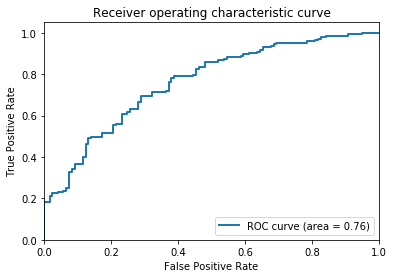

In [37]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split

classifier = GaussianMixture(n_components=2, covariance_type="spherical")
print("Gaussian Mixture results")
plot_roc_curve(classifier)

# Decision Tree Performance

Deciosion Tree Results


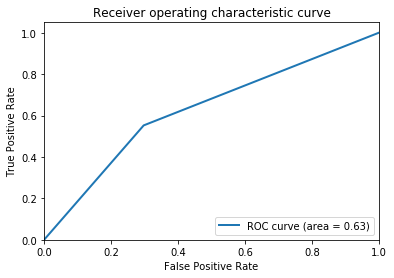

In [38]:
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier()
print("Deciosion Tree Results")
plot_roc_curve(classifier)

# Random Forest Performance

Random Forest results


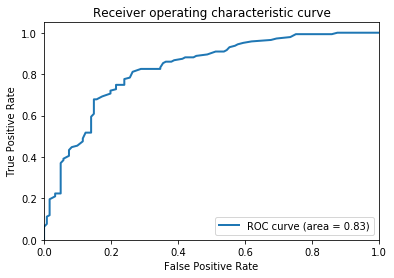

In [39]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
print("Random Forest results")
plot_roc_curve(classifier)

# Support Vector Classifier Performance

Support Vector Classifier Results


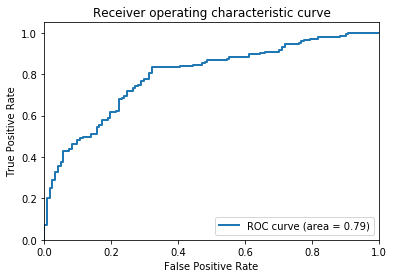

In [40]:
from sklearn.svm import SVC
classifier = SVC(probability = True)
print("Support Vector Classifier Results")
plot_roc_curve(classifier)